In [1]:
 PYDEVD_DISABLE_FILE_VALIDATION=1

In [3]:
E0.optimize()
E0.reactions.ALAR.flux

0.0

In [1]:
import cobra
from cobra.io import load_model
import cometspy as c
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

os.environ['COMETS_HOME'] = 'C:\\Program Files\\comets'

# Monoculture vs coculture


## initialization

In [2]:
#E0
E0 = cobra.io.read_sbml_model("./models/iML1515_E0.xml")
S0 = cobra.io.read_sbml_model("./models/STM_v1_0_S0.xml")

E = c.model(E0)
E.open_exchanges()
E.initial_pop = [0, 0, .5e-4]
E.obj_style = "MAX_OBJECTIVE_MIN_TOTAL" 

S = c.model(S0)
S.open_exchanges() 
S.initial_pop = [0, 0, .5e-4]
S.obj_style = 'MAX_OBJECTIVE_MIN_TOTAL' # parsimonious FBA

p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", 200)
p.set_param("timeStep", 1) 

In [ ]:
E.initial_pop = [0, 0, .5e-4]
S.initial_pop = [0, 0, .5e-4]
p.set_param("maxCycles", 200)


In [3]:
def create_common_media(Species = [E,S], carbon_source = "lcts_e", carbon_source_val = 10, 
                        nutrients_val = 100, add_nutrient = '', add_nutrient_val = [100]):
    # carbon_source = 'lcts_e', 'ac_e' or 'glc__D_e'
    # add_nutrient = 'met__L_e' for E.coli monoculture
    
    # convert into list for enumeration 
    if type(add_nutrient)  == str:
        add_nutrient = [add_nutrient]
    if type(add_nutrient_val)  == int:
        add_nutrient_val = [add_nutrient_val]
        
    l = c.layout(Species)
    l.obj_style = 'MAX_OBJECTIVE_MIN_TOTAL' # parsimonious FBA
    
    base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
                  "mn2_e", "mobd_e", "ni2_e", "o2_e", "pi_e", "so4_e", "zn2_e","nh4_e"]
    for nutrient in base_nutrients:
        l.set_specific_metabolite(nutrient, nutrients_val)
        
    if (add_nutrient != ['']):
        if (len(add_nutrient) == len(add_nutrient_val)):
            for _,i in enumerate(zip(add_nutrient, add_nutrient_val)): 
                l.set_specific_metabolite(i[0], i[1])
        else:
            print(f'Set all additional nutrients to {add_nutrient_val[0]}')
            for _,i in enumerate(add_nutrient): 
                l.set_specific_metabolite(i, add_nutrient_val[0])
    
    l.set_specific_metabolite(carbon_source, carbon_source_val)  
    return(l)
   
# E_layout = create_common_media([E],carbon_source = 'ac_e',add_nutrient = ['zn2_e'], add_nutrient_val = 10)
# E_layout.media['init_amount'][E_layout.media['metabolite'] == 'zn2_e'] # check media initializations 

# E0, S0 Monocultures and coculutre
E0 in lcts_e, met__L_e medium 
S0 in ac_e medium

In [4]:
E_layout = create_common_media([E], carbon_source='lcts_e', add_nutrient='met__L_e', add_nutrient_val=10)
sim_E0_mono = c.comets(E_layout, p)
sim_E0_mono.run()
# E_layout.media['init_amount'][E_layout.media['metabolite'] == 'met__L_e'] # check media initializations 


Running COMETS simulation ...
Done!


In [5]:
S_layout_ac = create_common_media([S], carbon_source='ac_e')  
sim_S0_mono_ac = c.comets(S_layout_ac, p)
sim_S0_mono_ac.run(); 


Running COMETS simulation ...
Done!


S0 in glc__D_e medium

In [6]:
S_layout_glc = create_common_media([S], carbon_source='glc__D_e',carbon_source_val=10) 
sim_S0_mono_glc = c.comets(S_layout_glc, p)
sim_S0_mono_glc.run();



Running COMETS simulation ...
Done!


## combind E0 S0

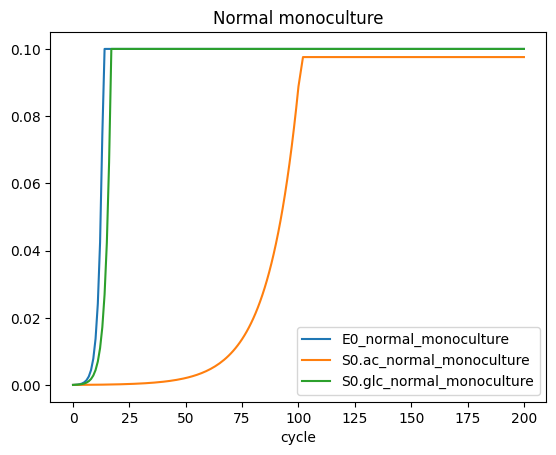

In [7]:
sim_E0_mono.total_biomass = sim_E0_mono.total_biomass.rename(columns={'iML1515': 'E0_normal_monoculture'})
sim_E0_mono.total_biomass['S0.ac_normal_monoculture'] = sim_S0_mono_ac.total_biomass.iloc[:,1]
sim_E0_mono.total_biomass['S0.glc_normal_monoculture'] = sim_S0_mono_glc.total_biomass.iloc[:,1]
sim_E0_mono.total_biomass.plot(x = 'cycle');
plt.title('Normal monoculture');

sim_E0_mono.total_biomass.to_csv('./r/data fitting/monocultures.csv')


Running COMETS simulation ...
Done!


,cycle,E0.lcts_normal_monoculture,S0.ac_normal_monoculture,S0.glc_normal_monoculture,E0_normal_coculture,S0_normal_coculture
0,0,0.000050,0.000050,0.000050,0.000050,0.000050
1,1,0.000088,0.000054,0.000078,0.000050,0.000050
2,2,0.000154,0.000058,0.000123,0.000050,0.000050
3,3,0.000270,0.000063,0.000192,0.000050,0.000051
4,4,0.000473,0.000067,0.000302,0.000053,0.000051
...,...,...,...,...,...,...
196,196,0.100000,0.097574,0.100000,0.067596,0.032404
197,197,0.100000,0.097574,0.100000,0.067596,0.032404
198,198,0.100000,0.097574,0.100000,0.067596,0.032404
199,199,0.100000,0.097574,0.100000,0.067596,0.032404


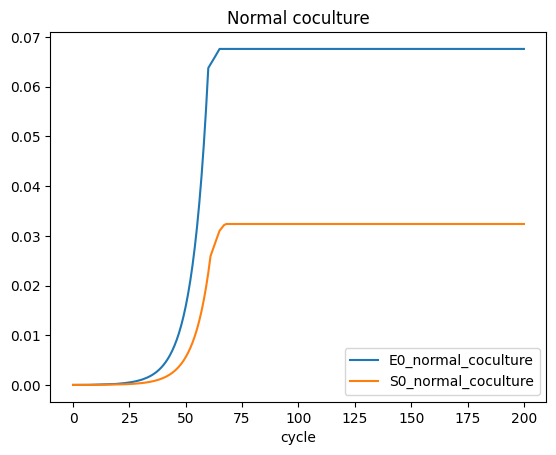

In [8]:
E.initial_pop = [0, 0, .5e-4]
S.initial_pop = [0, 0, .5e-4]
p.set_param("maxCycles", 200)

ES_layout = create_common_media([E,S])
sim_coculture = c.comets(ES_layout, p)
sim_coculture.run()
sim_coculture.total_biomass = sim_coculture.total_biomass.rename(columns={'iML1515': 'E0_normal_coculture',  'STM_v1_0': 'S0_normal_coculture'})
sim_coculture.total_biomass.plot(x = "cycle");
plt.title('Normal coculture');

sim_coculture.total_biomass.insert(1,'S0.glc_normal_monoculture', sim_E0_mono.total_biomass['S0.glc_normal_monoculture'])
sim_coculture.total_biomass.insert(1,'S0.ac_normal_monoculture', sim_E0_mono.total_biomass['S0.ac_normal_monoculture'])
sim_coculture.total_biomass.insert(1,'E0.lcts_normal_monoculture', sim_E0_mono.total_biomass['E0_normal_monoculture'])
sim_coculture.total_biomass

# Define Gene Inhibition Functions

In [9]:
# Create old_bound matrix
def get_old_bounds(model):
    old_bounds = pd.DataFrame()
    for i, rct in enumerate(model.reactions):
        old_bounds = pd.concat([old_bounds,
                   pd.DataFrame({'reaction': rct.id,
                                 'lower_bound': rct.lower_bound,
                                 'upper_bound': rct.upper_bound},
                                index = [0])])
    return(old_bounds.set_index('reaction'))

E_old_bounds = get_old_bounds(E0)
S_old_bounds = get_old_bounds(S0)

In [57]:
# gene inhibition
def get_gene_id(model, gene_name):
    for _,i in enumerate(model.genes):
        if(i.name == gene_name):
            return(i.id)

def get_bool_inhibit_reaction_i(model0, gene, reaction_i):
    # function for generating boolean for knockout of reaction_i
    # pass single gene as str or double gene as list
    # reaction_i as reaction object in the metabolic model 
    # return Boolean, True for inhibition
    # sample input: get_bool_inhibit_reaction_i(E0, ['folA','folM'], E0.reactions.DHFR)
    
    # moved to upper level function
#     if (type(gene) == str): # convert into list for iteration if single gene is passed
#         gene = [gene]
    
    reaction_inhibition_check = str(reaction_i.gpr).split('or') # all sets of genes that regulate reaction_i
    gene_inhibition_sublist = list() # store if inhibition gene candidates are in the set of genes
    for i, item in enumerate(reaction_inhibition_check):
#         print(reaction_inhibition_check)
        for j, gene_j in enumerate(gene):
            gene_id = get_gene_id(model0, gene_j)
#             print(item, gene_j)
            if (str(item).__contains__(gene_id)):
                gene_inhibition_sublist.append(item)
                
    if (len(reaction_inhibition_check) == len(gene_inhibition_sublist)): # all sets of genes being inhibited
        bool_inhibit = True
    else: 
        bool_inhibit = False
    
    return(bool_inhibit)

def get_sim_solution_object(Species = [E], carbon_source = "lcts_e", carbon_source_val = 10, 
                        nutrients_val = 100, add_nutrient = '', add_nutrient_val = [100]): 
    # function creating media and return simulation solution object 
    
    layout = create_common_media(Species, carbon_source, carbon_source_val, nutrients_val, add_nutrient, add_nutrient_val)
    sim = c.comets(layout, p)
    sim.run();
    return(sim)

def rename_df(df, gene, culture = 'monoculture'): # change default naming of COMET solution total biomass matrix 
    return(df.rename(columns={'iML1515': f'E0_{gene}_inhibition_{culture}',  
                              'STM_v1_0': f'S0_{gene}_inhibition_{culture}'})) 

def change_and_save_scaled_bounds(gene, scale = 0, option_NG_knock_out = True): 
    # pass only one gene as the first argument 
    # scaling = 0 corresponding to one of the bounds will be set to 0 
    # scaling on net lower bound, which is relative to net upper bound
    # upper bound is set to be 1/2 of the corresponding lower bound of FVA flux
    # boolean option_NG_knock_out: indication of knocking out non-essential gene
    
    if (type(gene) == str): # convert into list for iteration if single gene is passed
        gene = [gene]   
    title_string = ''
    for _, gene_current_iter in enumerate(gene): # gene_current_iter as single gene
        
        bound_mat_size = max(len(E0.genes.get_by_id(get_gene_id(E0, gene_current_iter)).reactions),
                             len(S0.genes.get_by_id(get_gene_id(S0, gene_current_iter)).reactions))
         
        for k, (model, model0) in enumerate(zip([E, S],[E0, S0])): # iterate through model to inhibit reaction in both E0 and S0
            for i, reaction_i in enumerate(model0.genes.get_by_id(get_gene_id(model0, gene_current_iter)).reactions): # iterate through reactions of the current gene           
                reaction_id = reaction_i.id
                
                if (option_NG_knock_out == True 
                    and gene_current_iter in non_essential_genes
                    and get_bool_inhibit_reaction_i(model0, gene, reaction_i)): 
                    # ko reaction if reaction_i is uniquely controlled by the gene 
                    model.change_bounds(reaction_id, 0, 0)     
                    
                else: # set bounds according to FVA bounds
                    if (k==0): 
                        model_half_lb = reaction_bounds.loc[reaction_i.id]['FVA_E0']/2 
                    else:
                        model_half_lb = reaction_bounds.loc[reaction_i.id]['FVA_S0_ac']/2

                    if (model_half_lb >= 0):
                        model.change_bounds(reaction_id, model_half_lb*scale, model_half_lb)
                    else:
                        model.change_bounds(reaction_id, model_half_lb, model_half_lb*scale)

                if (k==0): # model.name != E0 
                    title_string += f'E0 {reaction_id}: ({round(E.get_bounds(reaction_id)[0],5)},{round(E.get_bounds(reaction_id)[1],5)})'
                else:
                    title_string += f' S0 {reaction_id}: ({round(S.get_bounds(reaction_id)[0],5)},{round(S.get_bounds(reaction_id)[1],5)})'
                if ((i % 2 == 0) & (i > 0)):
                    title_string += '\n' 
    return(title_string)

def restore_bounds(gene):
    if (type(gene) == str): # convert into list for iteration if single gene is passed
        gene = [gene]  
    
    for _, gene_current_iter in enumerate(gene): # gene_current_iter as single gene
        for k, (model, model0, model_old_bounds) in enumerate(zip([E, S],[E0, S0], [E_old_bounds, S_old_bounds])): # iterate through E0 object and S0 objects
            for i, reaction_i in enumerate(model0.genes.get_by_id(get_gene_id(model0, gene_current_iter)).reactions):                
                reaction_id = reaction_i.id
                model.change_bounds(reaction_id, model_old_bounds.loc[reaction_id][0], model_old_bounds.loc[reaction_id][1])
                
def cal_total_biomass(essential_genes, maxCycles = 200, tstep = 1, scale = 0, option_NG_knock_out = True, 
                      monoculture_E0 = True, monoculture_S0_ac = True, monoculture_S0_glc = False,
                      monoculture = True, coculture = True,  new_mat = False, 
                      use_title_str = False, gen_plots = False):    
    # Single gene inhibiton sample input: cal_total_biomass('thrB')
    # Gene pairs inhibition sample input: cal_total_biomass(itertools.combinations(non_essential_genes, 2))
    
    # maxCycles, tstep as input to p.set_param()
    # scale, option_NG_knock_out as input to change_and_save_scaled_bounds
    # boolean xxculture_xxx : choice to run corresponding cocultures
    # boolean new_mat: include results from normal cultures 
    # boolean use_title_str: use of title string for checking bounds of the simulation object
    # boolean gen_plots: generation of plots from monoculture and coculture simulations
    # return biomass matrix that concated all sim.total_biomass 
     
    p.set_param("timeStep", tstep) 
    p.set_param("maxCycles", maxCycles)
    if (new_mat == True): # return new biomass matrix 
        biomass_mat = pd.DataFrame() # concate with normal coculture matrix
    else:
        biomass_mat = sim_coculture.total_biomass.rename(columns={'E0': 'E0_normal_coculture',  'S0': 'S0_normal_coculture'})

    if (type(essential_genes) == str): # cater for single gene input for enumeration 
        essential_genes = [essential_genes]
        use_title_str = True # title_str from function change_and_save_scaled_bounds, with reactions and bounds
    
    for _, gene in enumerate(essential_genes):   
        print(gene)
        title_string = change_and_save_scaled_bounds(gene, scale, option_NG_knock_out)

        if (monoculture == True):
            if (monoculture_E0 == True):  
                sim_mono_E = get_sim_solution_object([E], carbon_source='lcts_e', add_nutrient='met__L_e', add_nutrient_val=10)
                sim_mono_E.total_biomass = sim_mono_E.total_biomass.rename(columns={'iML1515': f'E0.lcts_{gene}_monoculture'})
            else:
                monoculture = False # Stop runnning code that contains sim_mono_E
            
            if (monoculture_S0_ac == True):
                sim_mono_S_ac = get_sim_solution_object([S], carbon_source='ac_e')                

            if (monoculture_S0_glc == True):
                sim_mono_S_glc = get_sim_solution_object([S], carbon_source='glc__D_e')

            if (monoculture_E0 == True): 
                if (monoculture_S0_ac == True):
                    sim_mono_E.total_biomass[f'S0.ac_{gene}_monoculture'] = sim_mono_S_ac.total_biomass.iloc[:,1] 
                if (monoculture_S0_glc == True):
                    sim_mono_E.total_biomass[f'S0.glc_{gene}_monoculture'] = sim_mono_S_glc.total_biomass.iloc[:,1] 
            
                if (gen_plots == True): 
                    sim_mono_E.total_biomass.plot(x = 'cycle')
                    if (use_title_str == False):
                        plt.title(f'{gene} inhibition, Monoculture')
                    else:
                        plt.title('Monoculture\n'+ title_string)

                if (coculture == False):
                    biomass_mat = pd.concat([biomass_mat, rename_df(sim_mono_E.total_biomass.iloc[:,1:], gene)],axis = 1)

        if (coculture == True):    
            ES_layout = create_common_media([E,S], carbon_source='lcts_e')
            sim_co = c.comets(ES_layout, p) 
            sim_co.run()
            sim_co.total_biomass = sim_co.total_biomass.rename(columns={'iML1515': f'E0_{gene}_coculture',
                                                                        'STM_v1_0': f'S0_{gene}_coculture'})
            if (gen_plots == True): # plot change in biomass
                sim_co.total_biomass.plot(x = "cycle")
                if (use_title_str == False):
                    plt.title(f'{gene} inhibition, Coculture')
                else:
                    plt.title(f'Coculture\n{title_string}')
            
            if (monoculture == True):
                sim_co.total_biomass = pd.concat([sim_mono_E.total_biomass, rename_df(sim_co.total_biomass.iloc[:,1:],gene,culture='coculture')], axis = 1)
            biomass_mat = pd.concat([biomass_mat, rename_df(sim_co.total_biomass.iloc[:,1:],gene,culture='coculture')],axis = 1)

        restore_bounds(gene)
    return(biomass_mat)
# thrB_inhibition = cal_total_biomass('thrB', 10,35, new_mat=True)
# thrB_inhibition = cal_total_biomass('pyrE', 50,0.3, monoculture=False)

def rename_gene_pair_column(df):
    df.columns = [x.replace('(\'','').replace('\', \'', '&').replace('\')','') for x in df.columns]

# Single Gene inhibition
bounds are the FBA lower bounds in lcts and met medium for E0 and acetate medium for S0

In [11]:
ko_genes = pd.read_csv('.\Drug_gene_Similarity\ko_genes.csv', index_col=0, header = None)
# Knockout genes for both E.coli and S.enterica
ko_genes = [ x for x in ko_genes.loc['Both',:] if str(x) != 'nan']
ko_genes.extend(['folA', 'folP']) 
    

In [30]:
essential_genes = ['purU', 'pyrE', 'thrB', 'yrbG', 'folA', 'folP']

# unbounded for reactions that with genetic redundancy for non-essential genes
# knockout remaining reactions for non-essential genes
non_essential_genes = list(set(ko_genes)-set(essential_genes))
# reaction_bounds = pd.read_csv('FVA_bounds_inc_neg.csv', index_col=0)
reaction_bounds = pd.read_csv('.\Drug_gene_Similarity\FVA_bounds_inc_neg_manual01.csv', index_col=0)

# reaction_bounds_ko_reaction_NG = reaction_bounds.copy() # 0 bounds for the reactions 
# for i, current_gene in enumerate(non_essential_genes):
#     for _, current_reaction in enumerate(S0_ac.genes.get_by_id(get_gene_id(S0_ac, current_gene)).reactions):
#         reaction_bounds_ko_reaction_NG.loc[current_reaction.id]['FVA_S0_ac':'FVA_S0_glc'] = 0


## coculture result

In [ ]:
E.initial_pop = [0, 0, .5e-4]
S.initial_pop = [0, 0, .5e-4]
biomass_single_gene_inhibition = cal_total_biomass(ko_genes,200,monoculture_S0_glc=True,new_mat = False);

In [62]:
biomass_single_gene_inhibition_koNG = cal_total_biomass(ko_genes,200,monoculture_S0_glc=True,
                                                        option_NG_knock_out=True, new_mat = False);
%store biomass_single_gene_inhibition_koNG

rffG

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
dsbC

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
fhuD

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
sucB

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
dld

Running COMETS simulation ...
Error: COMETS simulation did not complete

     examine comets.run_output for the full java trace

     if we detect a common reason, it will be stated in the RuntimeError at the bottom


RuntimeError: COMETS simulation did not complete:
 undetected reason. examine comets.run_output for JAVA trace

## store coculture result into csv

In [ ]:
%store biomass_single_gene_inhibition
biomass_single_gene_inhibition.to_csv('./r/data fitting/biomass_SG.csv')

In [37]:
%store biomass_single_gene_inhibition_koNG
biomass_single_gene_inhibition_koNG.to_csv('./r/data fitting/biomass_SG_koNG.csv')

Stored 'biomass_single_gene_inhibition_koNG' (DataFrame)


# Gene pairs inhibitions(adjusted initial population)


In [ ]:
E = c.model(E0)
E.open_exchanges()
E.initial_pop = [0, 0, .5e-4]

S = c.model(S0)
S.open_exchanges() 
S.initial_pop = [0, 0, .5e-4]

p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", 200)
p.set_param("timeStep", 1) 
# _ = cal_total_biomass('sucA', 200,use_title_str = True) # gene pairs enumeration

In [ ]:
biomass_gene_pairs_inhibition_EG = cal_total_biomass(itertools.combinations(essential_genes, 2),200,
                                                     monoculture_S0_glc=True, use_title_str = False, gen_plots = True); # gene pairs enumeration

Non-essential genes

In [67]:
biomass_gene_pairs_inhibition_NG = cal_total_biomass(itertools.combinations(non_essential_genes, 2), 150,
                                                     option_NG_knock_out = True, 
                                                     monoculture=True, monoculture_S0_glc=True, use_title_str = False); # gene pairs enumeration
rename_gene_pair_column(biomass_gene_pairs_inhibition_NG)
%store biomass_gene_pairs_inhibition_NG

('fepG', 'pykF')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('fepG', 'kdgT')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('fepG', 'ccmB')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('fepG', 'dsbC')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('fepG', 'sucB')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('fepG', 'glpD')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('fepG', '

Done!

Running COMETS simulation ...
Done!
('ccmB', 'rffG')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('ccmB', 'sucA')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('ccmB', 'dld')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('ccmB', 'torA')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('dsbC', 'sucB')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('dsbC', 'glpD')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Runn

Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('lpp', 'fhuD')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('lpp', 'rffG')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('lpp', 'sucA')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('lpp', 'dld')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('lpp', 'torA')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('mltA', 'fhuD')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running C

In [68]:
# Test for 30 random combinations between essential and non_essential_genes 
import random
ENE_pairs = [(w,f) for w in essential_genes for f in non_essential_genes]
test_combined_choice = [random.choice(ENE_pairs) for _ in range(50)]
test_combined_choice
biomass_gene_pairs_inhibition_rndcomb = cal_total_biomass(test_combined_choice, 200,monoculture=True,
                                                          use_title_str = True, gen_plots=False); # gene pairs enumeration
rename_gene_pair_column(biomass_gene_pairs_inhibition_rndcomb)
%store biomass_gene_pairs_inhibition_rndcomb


('pyrE', 'rffG')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('yrbG', 'torA')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('thrB', 'rffG')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('yrbG', 'nrdE')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('folP', 'mltA')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('thrB', 'glpD')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('purU', 'nrdE')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
('yrbG', 'dsbC')

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COME

In [69]:
biomass_single_gene_inhibition_koNG = cal_total_biomass(ko_genes,200,monoculture_S0_glc=True,
                                                        option_NG_knock_out=True, new_mat = False);
%store biomass_single_gene_inhibition_koNG

rffG

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
dsbC

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
fhuD

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
sucB

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
dld

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
ccmB

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!
pykF

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Run

# Verification of biomass by changing bounds from cobra model

In [13]:
# read old model 
E_WT = cobra.io.read_sbml_model("./models/iML1515.xml")
S_WT = cobra.io.read_sbml_model("./models/STM_v1_0.xml")

## Test on this


Running COMETS simulation ...
Done!
(0.0, 1000.0)
(0.0, 1000.0)
(0.0, 1000.0)
(0.0, 1000.0)


<Axes: xlabel='cycle'>

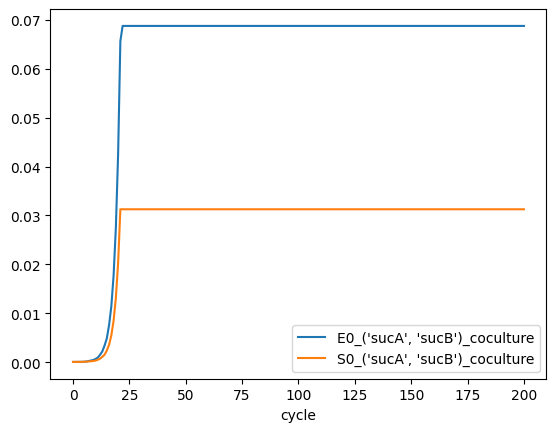

In [14]:
essential_genes = ['purU', 'pyrE', 'thrB', 'yrbG', 'folA', 'folP']
G = 1
scale = 0
# for _, gene in enumerate(itertools.combinations(['sucA','manY'], 2)):
EG = ['sucA','sucB']

for toggle_first, gene in enumerate(itertools.combinations(EG, 2)):
    # change bounds
    for _, gene_current_iter in enumerate(gene): # gene_current_iter as single gene
        for k, (model, model0) in enumerate(zip([E, S],[E0, S0])):
            for i, reaction_i in enumerate(model0.genes.get_by_id(get_gene_id(model0, gene_current_iter)).reactions):                
                reaction_id = reaction_i.id
                
#                 if(toggle_first == 0 and G ==1):
                if (k==0):
                    model_half_lb = reaction_bounds.loc[reaction_i.id]['FVA_E0']/2 
                else:
                    model_half_lb = reaction_bounds.loc[reaction_i.id]['FVA_S0_ac']/2

                if (model_half_lb >= 0):
                    model0.reactions.get_by_id(reaction_id).bounds = (model_half_lb*scale, model_half_lb)
                else:
                    model0.reactions.get_by_id(reaction_id).bounds = (model_half_lb, model_half_lb*scale)

            if (k==0):
                E_model = c.model(model0)
                E_model.open_exchanges()
                E_model.initial_pop = [0, 0, .5e-4]
                E_model.obj_style = "MAX_OBJECTIVE_MIN_TOTAL" 

            else:
                S_model = c.model(model0)
                S_model.open_exchanges() 
                S_model.initial_pop = [0, 0, .5e-4]
                S_model.obj_style = 'MAX_OBJECTIVE_MIN_TOTAL' # parsimonious FBA

    ES_layout = create_common_media([E_model,S_model], carbon_source='lcts_e')
    sim_co = c.comets(ES_layout, p) 
    sim_co.run()
    sim_co.total_biomass = sim_co.total_biomass.rename(columns={'iML1515': f'E0_{gene}_coculture',
                                                                'STM_v1_0': f'S0_{gene}_coculture'})

    for _, gene_current_iter in enumerate(gene): # gene_current_iter as single gene 
        for k, (model, model0) in enumerate(zip([E, S],[E0, S0])): 
            for i, reaction_i in enumerate(model0.genes.get_by_id(get_gene_id(model0, gene_current_iter)).reactions):                
    #                 print(model0.id, reaction_i, reaction_bounds.loc[reaction_i.id]['FVA_E0'])
                reaction_id = reaction_i.id
                if (k==0):
                    model0.reactions.get_by_id(reaction_id).bounds = E_WT.reactions.get_by_id(reaction_id).bounds 
                else:
                    model0.reactions.get_by_id(reaction_id).bounds = S_WT.reactions.get_by_id(reaction_id).bounds 

                print(model0.reactions.get_by_id(reaction_id).bounds)

sim_co.total_biomass.to_csv('./r/data fitting/test.csv')
sim_co.total_biomass.plot(x = "cycle")

## adjust GLCptspp and AKGDH reaction bounds



Constraining GLCptspp reaction in E0 has no effect in monoculture, but result in zero growth in coculture. 
(Note: GLCptspp one of the reactions regulated by 'manY', and this reaction is not uniquely controlled by gene 'manY')

Constraining AKGDH reaction in E0 leads to a shift in phenotypic phase plane regions 
change occurs when upper bound of AKGDH reaction drop to 0, specifically from (0,10) to (0,2)
(Note: AKGDH is co-regulated by lpdA, sucA and sucB)

In [44]:
print('GLCptspp: ',str(E0.reactions.GLCptspp.gpr))
print('AKGDH: ',str(E0.reactions.AKGDH.gpr))

GLCptspp:  (b1621 and b2415 and b2417 and b2416) or (b1101 and b2416 and b2415 and b2417) or (b1819 and b2415 and b1818 and b1817 and b2416)
AKGDH:  b0727 and b0116 and b0726


### GLCptspp reaction(also by many other genes)

In [19]:
reaction_bounds.loc['GLCptspp']
# E0.reactions.GLCptspp

FVA_E0        10.0
FVA_S0_ac      0.0
FVA_S0_glc    10.0
Name: GLCptspp, dtype: float64


Running COMETS simulation ...
Done!


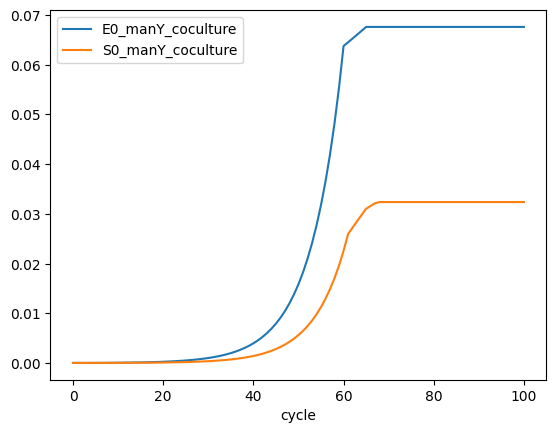

In [28]:
# knockout sucA
p.set_param("maxCycles", 100)
gene = 'manY'

with E0:
    with S0:
#         for i,rct in enumerate(E0.genes.get_by_id(get_gene_id(E0, gene)).reactions):
#             E0.reactions.get_by_id(rct.id).knock_out()
#         for i,rct in enumerate(S0.genes.get_by_id(get_gene_id(S0, gene)).reactions):
#             S0.reactions.get_by_id(rct.id).knock_out()
        E0.reactions.get_by_id('GLCptspp').bounds = (0,2)
#         S0.genes.get_by_id(get_gene_id(S0, gene)).knock_out()
                    
        E_model = c.model(E0)
        E_model.open_exchanges()
        E_model.initial_pop = [0, 0, .5e-4]
        E_model.obj_style = "MAX_OBJECTIVE_MIN_TOTAL" 

        S_model = c.model(S0)
        S_model.open_exchanges() 
        S_model.initial_pop = [0, 0, .5e-4]
        S_model.obj_style = 'MAX_OBJECTIVE_MIN_TOTAL' # parsimonious FBA

        ES_layout = create_common_media([E_model,S_model], carbon_source='lcts_e')
        sim_co = c.comets(ES_layout, p) 
        sim_co.run()
        sim_co.total_biomass = sim_co.total_biomass.rename(columns={'iML1515': f'E0_{gene}_coculture',
                                                                    'STM_v1_0': f'S0_{gene}_coculture'})
        sim_co.total_biomass.to_csv('./r/data fitting/test.csv')
        sim_co.total_biomass.plot(x = "cycle")

In [26]:
# knockout sucA
p.set_param("maxCycles", 100)
gene = 'manY'

with E0:
    with S0:
        E0.genes.get_by_id(get_gene_id(E0, gene)).knock_out()
        S0.genes.get_by_id(get_gene_id(S0, gene)).knock_out()

        for i,rct in enumerate(E0.genes.get_by_id(get_gene_id(E0, gene)).reactions):
            print(E0.name,rct.id,E0.reactions.get_by_id(rct.id).upper_bound)
        for i,rct in enumerate(S0.genes.get_by_id(get_gene_id(S0, gene)).reactions):
            print(S0.name,rct.id,S0.reactions.get_by_id(rct.id).upper_bound)
#             S0.reactions.get_by_id(rct.id).knock_out()

                    
        print()

None 2DGLCptspp 0
None ACMANAptspp 0
None FRUpts2pp 0
None GAMptspp 0
None MANptspp 0
None GLCptspp 1000.0
None ACMANAptspp 0
None GLCptspp 1000.0
None MANptspp 0
None FRUpts2pp 0
None GAMptspp 0



### AKGDH reaction


Running COMETS simulation ...
Done!


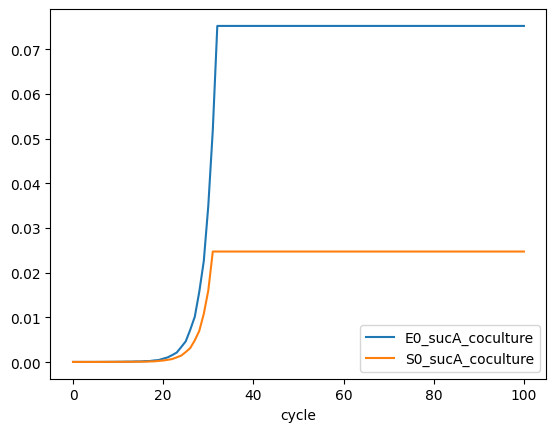

In [258]:
# knockout sucA
p.set_param("maxCycles", 100)

gene = 'sucA'
with E0:
    with S0:
        E0.reactions.AKGDH.bounds = (0,2)
#         S0.reactions.AKGDH.knock_out()
        E_model = c.model(E0)
        E_model.open_exchanges()
        E_model.initial_pop = [0, 0, .5e-4]
        E_model.obj_style = "MAX_OBJECTIVE_MIN_TOTAL" 

        S_model = c.model(S0)
        S_model.open_exchanges() 
        S_model.initial_pop = [0, 0, .5e-4]
        S_model.obj_style = 'MAX_OBJECTIVE_MIN_TOTAL' # parsimonious FBA

        ES_layout = create_common_media([E_model,S_model], carbon_source='lcts_e')
        sim_co = c.comets(ES_layout, p) 
        sim_co.run()
        sim_co.total_biomass = sim_co.total_biomass.rename(columns={'iML1515': f'E0_{gene}_coculture',
                                                                    'STM_v1_0': f'S0_{gene}_coculture'})
        sim_co.total_biomass.to_csv('./r/data fitting/test.csv')
        sim_co.total_biomass.plot(x = "cycle")


Running COMETS simulation ...
Done!


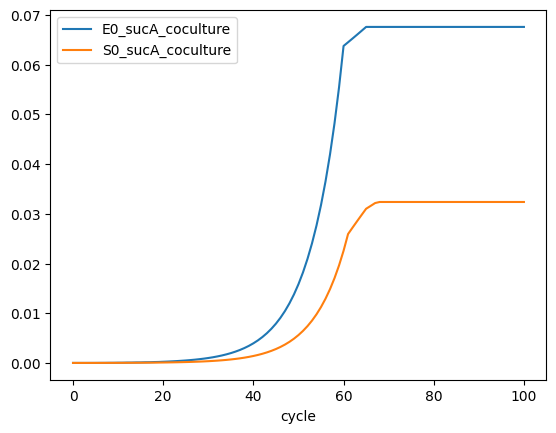

In [257]:
# knockout sucA
p.set_param("maxCycles", 100)
gene = 'sucA'

with E0:
    with S0:
        E0.reactions.AKGDH.bounds = (0,10)
#         S0.reactions.AKGDH.knock_out()
        E_model = c.model(E0)
        E_model.open_exchanges()
        E_model.initial_pop = [0, 0, .5e-4]
        E_model.obj_style = "MAX_OBJECTIVE_MIN_TOTAL" 

        S_model = c.model(S0)
        S_model.open_exchanges() 
        S_model.initial_pop = [0, 0, .5e-4]
        S_model.obj_style = 'MAX_OBJECTIVE_MIN_TOTAL' # parsimonious FBA

        ES_layout = create_common_media([E_model,S_model], carbon_source='lcts_e')
        sim_co = c.comets(ES_layout, p) 
        sim_co.run()
        sim_co.total_biomass = sim_co.total_biomass.rename(columns={'iML1515': f'E0_{gene}_coculture',
                                                                    'STM_v1_0': f'S0_{gene}_coculture'})
        sim_co.total_biomass.to_csv('./r/data fitting/test.csv')
        sim_co.total_biomass.plot(x = "cycle")

# store variables

In [33]:
biomass_gene_pairs_inhibition_NG

,cycle,E0.lcts_normal_monoculture,S0.ac_normal_monoculture,S0.glc_normal_monoculture,E0_normal_coculture,S0_normal_coculture,"E0_('rffG', 'lpp')_coculture","S0_('rffG', 'lpp')_coculture","E0_('rffG', 'pykF')_coculture","S0_('rffG', 'pykF')_coculture",...,"E0_('kdgT', 'torA')_coculture","S0_('kdgT', 'torA')_coculture","E0_('kdgT', 'glpD')_coculture","S0_('kdgT', 'glpD')_coculture","E0_('manY', 'torA')_coculture","S0_('manY', 'torA')_coculture","E0_('manY', 'glpD')_coculture","S0_('manY', 'glpD')_coculture","E0_('torA', 'glpD')_coculture","S0_('torA', 'glpD')_coculture"
0,0,0.000050,0.000050,0.000050,0.000050,0.000050,0.00005,0.00005,0.00005,0.00005,...,0.000050,0.000050,0.000050,0.000050,0.00005,0.00005,0.00005,0.00005,0.000050,0.000050
1,1,0.000088,0.000054,0.000078,0.000050,0.000050,0.00005,0.00005,0.00005,0.00005,...,0.000050,0.000050,0.000050,0.000050,0.00005,0.00005,0.00005,0.00005,0.000050,0.000050
2,2,0.000154,0.000058,0.000123,0.000050,0.000050,0.00005,0.00005,0.00005,0.00005,...,0.000050,0.000050,0.000050,0.000050,0.00005,0.00005,0.00005,0.00005,0.000050,0.000050
3,3,0.000270,0.000063,0.000192,0.000050,0.000051,0.00005,0.00005,0.00005,0.00005,...,0.000050,0.000051,0.000050,0.000051,0.00005,0.00005,0.00005,0.00005,0.000050,0.000051
4,4,0.000473,0.000067,0.000302,0.000053,0.000051,0.00005,0.00005,0.00005,0.00005,...,0.000053,0.000051,0.000053,0.000051,0.00005,0.00005,0.00005,0.00005,0.000053,0.000051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,0.100000,0.097574,0.100000,0.067596,0.032404,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,197,0.100000,0.097574,0.100000,0.067596,0.032404,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,198,0.100000,0.097574,0.100000,0.067596,0.032404,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,199,0.100000,0.097574,0.100000,0.067596,0.032404,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
def rename_gene_pair_column(df):
    df.columns = [x.replace('(\'','').replace('\', \'', '&').replace('\')','') for x in df.columns]

rename_gene_pair_column(biomass_gene_pairs_inhibition_NG)
biomass_gene_pairs_inhibition_NG.to_csv('./r/data fitting/biomass_test.csv')

In [ ]:
def rename_gene_pair_column(df):
    df.columns = [x.replace('(\'','').replace('\', \'', '&').replace('\')','') for x in df.columns]

rename_gene_pair_column(biomass_gene_pairs_inhibition_NG)
%store biomass_gene_pairs_inhibition_NG
biomass_gene_pairs_inhibition_NG.to_csv('./r/data fitting/biomass_NG.csv')

In [ ]:
rename_gene_pair_column(biomass_gene_pairs_inhibition_EG)
%store biomass_gene_pairs_inhibition_EG
biomass_gene_pairs_inhibition_EG.to_csv('./r/data fitting/biomass_EG.csv')    

In [ ]:
%store biomass_single_gene_inhibition
biomass_single_gene_inhibition.to_csv('./r/data fitting/biomass_SG.csv')

In [ ]:
rename_gene_pair_column(biomass_gene_pairs_inhibition_rndcomb)
biomass_gene_pairs_inhibition_rndcomb.to_csv('./r/data fitting/biomass_rndcomb.csv')

# Ensure bounds remain unchanged after simulations
SHSL1 (0.0, 0.0)
FHL (0.0, 0.0) for E0

In [64]:
for i , r in enumerate(E0.reactions):
    if (E0.reactions.get_by_id(r.id).bounds[1]<1000):
        print(r.id, E0.reactions.get_by_id(r.id).bounds)

SHSL1 (0.0, 0.0)
FHL (0.0, 0.0)


In [38]:
E0.reactions.FHL.gpr
# E0.genes.b3939

cobra.core.gene.GPR('(b4079 and b2489 and b2487 and b2485 and b2482 and b2483 and b2486 and b2490 and b2488 and b2484 and b2481) or (b4079 and b2722 and b2723 and b2724 and b2720 and b2721 and b2719)')

In [58]:
for i , r in enumerate(E0.reactions):
    if (E0.reactions.get_by_id(r.id).bounds[1]<1000):
        print(r.id, E0.reactions.get_by_id(r.id).bounds)

SHSL1 (0.0, 0.0)
FHL (0.0, 0.0)


In [ ]:
for i , r in enumerate(E0.reactions):
    if (E.get_bounds(r.id)[1]<1000):
        print(r.id, E.get_bounds(r.id))

In [65]:
for i , r in enumerate(S0.reactions):
    if (S.get_bounds(r.id)[1]<1000):
        print(r.id, S.get_bounds(r.id))

ATPM (8.39, 8.39)
FHL (0.0, 0.0)
LDH_D (0.0, 0.0)
LDH_D2 (0.0, 0.0)
METtex (-1000.0, 0.0)
SPODM (0.0, 0.0)
SPODMpp (0.0, 0.0)
CAT (0.0, 0.0)
OAO4t3pp (0.0, 0.0)
OAO4t3ex (0.0, 0.0)
HISDr (0.0, 0.0)
AB6PGH (0.0, 0.0)
SARCOX (0.0, 0.0)
URCN (0.0, 0.0)
ENTERHpp (0.0, 0.0001)
SALCHS4Hpp (0.0, 0.0001)
SALCHS4FEHpp (0.0, 0.0001)
CHITPH (0.0, 0.0)
CHITOBpts (0.0, 0.0)
OA4L_ST (0.0, 0.0)
OA4VL_ST (0.0, 0.0)
